# Notebook de testing

- En este notebook hacemos los test.

## Librerías

In [278]:
# Librerías

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
from pathlib import Path
from scipy.stats import ttest_ind, chi2_contingency
from statsmodels.stats.proportion import proportions_ztest

# sube de notebooks/ a la raíz del repo

sys.path.append(str(Path.cwd().parent))

import src.functions as fc

%matplotlib inline 
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Data

In [279]:
df1 = pd.read_csv("https://raw.githubusercontent.com/data-bootcamp-v4/lessons/refs/heads/main/5_6_eda_inf_stats_tableau/project/files_for_project/df_final_demo.txt")
df2 = fc.load_data_merge("20260212_1519_df2_merged.csv")
df3 = pd.read_csv("https://raw.githubusercontent.com/data-bootcamp-v4/lessons/refs/heads/main/5_6_eda_inf_stats_tableau/project/files_for_project/df_final_experiment_clients.txt")

In [280]:
df2.head()

,client_id,visitor_id,visit_id,process_step,date_time
0,9988021,580560515_7732621733,781255054_21935453173_531117,step_3,2017-04-17 15:27:07
1,9988021,580560515_7732621733,781255054_21935453173_531117,step_2,2017-04-17 15:26:51
2,9988021,580560515_7732621733,781255054_21935453173_531117,step_3,2017-04-17 15:19:22
3,9988021,580560515_7732621733,781255054_21935453173_531117,step_2,2017-04-17 15:19:13
4,9988021,580560515_7732621733,781255054_21935453173_531117,step_3,2017-04-17 15:18:04


In [281]:
# Drop

df3 = df3.dropna()

## Tasa de finalización por grupo

In [304]:
tasa_finalizacion_control, tasa_finalizacion_test, df_control, df_test = fc.filtro_y_tasa(df3, df2)
tasa_finalizacion_control, tasa_finalizacion_test

(65.59, 69.29)

#### INSIGHT 1 DESCRIPTIVO · Tasa de finalización por grupo (Control vs Test)

- La **tasa de finalización** del grupo **Control** es del **65.59%**.
- La **tasa de finalización** del grupo **Test** es del **69.00%**.

- Descriptivamente, el grupo **Test** muestra un **mayor porcentaje de finalización** que el grupo Control. A partir de esta diferencia observada, en los próximos apartados del notebook vamos a **contrastar estadísticamente** si el aumento en finalización del diseño nuevo **es real o puede explicarse por azar**, y si la diferencia es **significativa** (y con qué magnitud).


## TEST 1. Comprobamos lo que la estadística descriptiva nos señala: ¿es la tasa de finalización igual en el grupo de test y el grupo de control?

In [305]:
# H0 -> tasa de finalización Test = control
# H1 -> tasa de finalización Test != control

finish_control = fc.finish(df_control)

finish_test = fc.finish(df_test)

_, p_value = ttest_ind(finish_control, finish_test, equal_var=False)

p_value

np.float64(8.009768670783661e-19)

### Insight 1 · Test 1

- El test 1 devuelve un `p-value = 8.01e-19`, que es **mucho menor** que `α = 0.05`.
- Por tanto, **rechazamos H0** (igualdad de tasas de finalización entre Control y Test) y aceptamos que **hay evidencia estadística de diferencia** entre grupos.

- En línea con la descriptiva (65.59% vs 69.00%), la conclusión es que la tasa de finalización del grupo **Test** es **distinta** a la del grupo **Control** de forma estadísticamente significativa al 5%.

### Visualización · Test 1

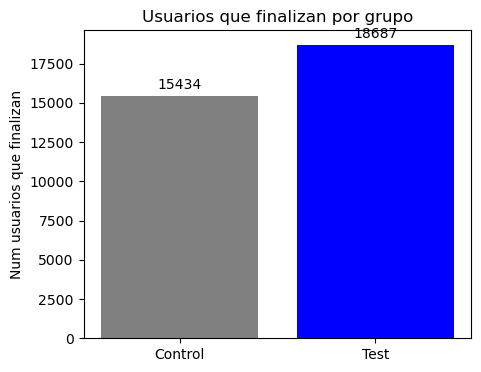

(<Figure size 500x400 with 1 Axes>,
 <Axes: title={'center': 'Usuarios que finalizan por grupo'}, ylabel='Num usuarios que finalizan'>)

In [309]:
fc.visualizacion_test_1(finish_control, finish_test)

### Tasa de crecimiento relativo

In [286]:
# tasa de crecimiento relativo = nuevo - antiguo / antiguo

tasa_crecimiento_relativo = (tasa_finalizacion_test - tasa_finalizacion_control) / tasa_finalizacion_control * 100

tasa_crecimiento_relativo

5.64110382680287

#### INSIGHT DESCRIPTIVO · Tasa de crecimiento relativo (lift)

- Calculamos la **tasa de crecimiento relativo** como:

  `((tasa_test - tasa_control) / tasa_control) * 100`

- El resultado es un **+5.64%**, lo que significa que la tasa de finalización del diseño **Test** es aproximadamente **un 5.64% mayor** que la del diseño **Control** en términos relativos.

- Dado que este lift **supera el umbral del 5%** definido por la empresa, **descriptivamente** el nuevo diseño cumple el criterio de mejora mínima y se considera **potencialmente rentable** desde el punto de vista de conversión.


## TEST 2. Testing por usuario hasta confirm (control vs test): ¿Es el grupo de test más rápido que el grupo de control?

In [287]:
# Constantes e hipótesis

ALPHA = 0.05
CONFIRM_STEP = "confirm"
ALT = "less"

# H0: test no es más rapido (igual o peor)
# H1: test es más rápido

In [288]:
# 1) Preparar datos de eventos (tipos y orden)

df_events = df2.copy()

df_events = fc.to_datetime(df_events)

control_times, test_times, df_times = fc.calcular_tiempo_para_test(df_events, df3)


In [289]:
# 2) TEST

_, p_value_times = ttest_ind(test_times, control_times, alternative="less", equal_var=False)

p_value_times

# Hay evidencia estadística a favor de H1. Se rechaza hipótesis
# nula y se acepta alternativa. 

np.float64(1.324369909605251e-05)

### INSIGHT DESCRIPTIVO · Velocidad (tiempo hasta `confirm`) Control vs Test

- En el test de **velocidad por usuario** (tiempo hasta `confirm`) comparando **Control vs Test**, obtuvimos un `p-value = 1.324e-05`.
- Como `p-value < 0.05`, **rechazamos la hipótesis nula** y concluimos que existe una **diferencia estadísticamente significativa** en el tiempo hasta `confirm` entre ambos grupos al 5%.

- En términos interpretativos: la diferencia de “velocidad” observada entre Control y Test **no parece explicarse por azar**; uno de los grupos completa el proceso en **menos tiempo** de forma significativa (según la dirección definida en la hipótesis alternativa) como podemos ver en la visualización siguiente.

### Visualización · Test 2

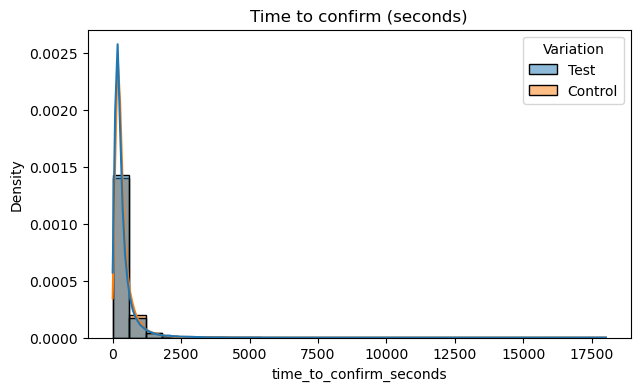

(<Figure size 700x400 with 1 Axes>,
 <Axes: title={'center': 'Time to confirm (seconds)'}, xlabel='time_to_confirm_seconds', ylabel='Density'>)

In [310]:
fc.visualizacion_test_2(df_times)

## TEST 3. Por edad promedio (Test vs Control): ¿Es la edad promedio de edad del grupo test igual a la del grupo control?

In [291]:
#H0 -> edad promedio Test = edad promedio Control 

#H1 -> edad promedio Test != edad promedio Control 

In [292]:
test_edad, control_edad, df_demo_ab = fc.preparar_grupos_experimento(df1, df3, "clnt_age")
_, p_value_age = ttest_ind(test_edad.dropna(), control_edad.dropna(), equal_var=False)

print(p_value_age)


0.015692719461388685


### INSIGHT DESCRIPTIVO · TEST 3 (Edad promedio) Control vs Test

- En el **Test 3** comparamos si la **edad promedio** del grupo **Test** es igual a la del grupo **Control**.
- El resultado fue `p-value = 0.0157`.

- Como `p-value < 0.05`, **rechazamos la hipótesis nula** y concluimos que existe una **diferencia estadísticamente significativa** en la edad promedio entre ambos grupos al 5%.
- Implicación: los grupos **no están perfectamente balanceados** en edad, lo que puede actuar como **factor de confusión** y conviene mencionarlo al interpretar las diferencias de finalización/velocidad.


### Visualización · Test 3

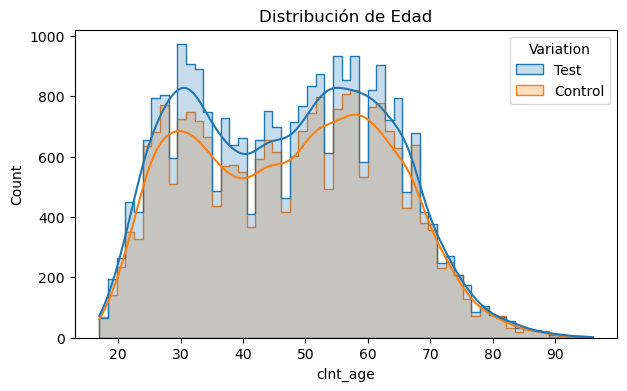

(<Figure size 700x400 with 1 Axes>,
 <Axes: title={'center': 'Distribución de Edad'}, xlabel='clnt_age', ylabel='Count'>)

In [312]:
fc.visualizacion_test_3(df_demo_ab)

- Comprobamos que las curvas de ambos grupos siguen la misma forma. Pero destacamos que el grupo Test tiene más usuarios encuestados que el grupo Control.

## TEST 4. Por permanencia promedio (Test vs Control): ¿Es la permanencia promedio del grupo test igual al del grupo control?

In [294]:
#H0 -> permanencia promedio Test = permanencia promedio Control

#H1 -> permanencia promedio Test != permanencia promedio Control

In [295]:
test_permanencia, control_permanencia, _ = fc.preparar_grupos_experimento(df1, df3, "clnt_tenure_yr")

In [296]:
_, p_value_permanencia = ttest_ind(test_permanencia.dropna(), control_permanencia.dropna(), equal_var=False)

print(p_value_permanencia)

0.08699034968593344


#### INSIGHT DESCRIPTIVO · TEST 4 (Permanencia promedio) Control vs Test

- En el **Test 4** evaluamos si la **permanencia promedio** (tenure) del grupo **Test** es igual a la del grupo **Control**.
- El resultado fue `p-value = 0.0870`.

- Como `p-value > 0.05`, **no podemos rechazar la hipótesis nula**: no hay evidencia estadística suficiente para afirmar que la permanencia promedio difiera entre ambos grupos al 5%.
- Esto es coherente con la visualización (boxplot), donde las distribuciones de permanencia se observan similares entre Control y Test.

### Visualización · Test 4

/Users/juaruibel/Projects/BOOTCAMP/Unit 05 - EDA and Inferential Stats/project2-cx-julio-juanjo/src/functions.py:430: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



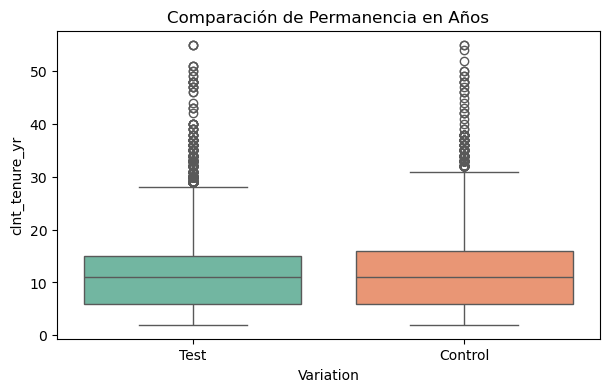

(<Figure size 700x400 with 1 Axes>,
 <Axes: title={'center': 'Comparación de Permanencia en Años'}, xlabel='Variation', ylabel='clnt_tenure_yr'>)

In [313]:
fc.visualizacion_test_4(df_demo_ab)

#### INSIGHT DESCRIPTIVO · Boxplot de permanencia (Control vs Test)

- En el boxplot se observa que el grupo **Control** presenta una **mediana de permanencia ligeramente superior** a la del grupo **Test**.
- Sin embargo, las distribuciones se solapan ampliamente y, en línea con el resultado del test (no significativo), **no hay evidencia de una diferencia relevante** en permanencia entre grupos.

- En consecuencia, podemos considerar que ambos grupos están **razonablemente equilibrados** en permanencia, y que esta variable **no debería sesgar de forma importante** la interpretación de los resultados del experimento.

## EXPORTACIÓN PARA TABLEAU

In [ ]:
# Exportacion para Tableau (3 datasets)

# 1) Tiempo hasta confirm por usuario (1 fila por client_id)
fc.save_data_clean_excel(df_times, "df_times")

# 2) Demografia + asignacion al experimento (df1 + df3)
fc.save_data_clean_excel(df_demo_ab, "df_demo_ab")

# 3) Eventos enriquecidos con Variation (para funnels/steps)
df_events_ab = df_events.merge(
    df3[["client_id", "Variation"]].drop_duplicates(),
    on="client_id",
    how="inner",
)
fc.save_data_clean_excel(df_events_ab, "df_events_ab")

